# Imports

In [542]:
import pandas as pd
import os
import seaborn as sns
import plotly.graph_objects as go
import matplotlib_inline

import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
from numpy.testing import assert_almost_equal

from urllib.request import urlretrieve

from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn import svm
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.metrics import zero_one_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *

from IPython.display import display, HTML, Image

from scipy.spatial.distance import pdist, cdist, squareform

pd.set_option('display.max_columns', None) # to display all columns

#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Preliminaries

Global variables

In [543]:
NR_BINS = 5

font_labels = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
current_path = os.getcwd()
image_path = os.path.join(current_path, "images")
tuning_path = os.path.join(current_path, "tuning")
results_path = os.path.join(current_path, "results")
datasets_path = os.path.join(current_path, "datasets")

We set up the folders hierarchy.

In [544]:
if not os.path.exists(image_path):
    os.makedirs(image_path)
if not os.path.exists(tuning_path):
    os.makedirs(tuning_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)
if not os.path.exists(datasets_path):
    os.makedirs(datasets_path)

# Utility functions

Plot images horizontally aligned

In [545]:
def showImagesHorizontally(files):
	n_files = len(files)
	fig, ax = plt.subplots(nrows=1, ncols=n_files)
	fig.set_size_inches(8 *n_files, 10)
	for i in range(n_files):
		#fig.add_subplot(1, n_files, i+1)
		image = plt.imread(files[i])
        
		ax[i].imshow(image, cmap='gray', aspect='equal', resample=False)
		ax[i].axis('off')

def showTablesHorizontally(dfs:list, captions:list, tablespacing=5):
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

def name(dataset_name):
	return dataset_name
    #return "_".join(['df', dataset_name])

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# INTRODUCTION

The goal of this project is make a score prediction of one film starting from its features.

We build the data pipeline studied during the course:
Data acquisition -> Data Pre-processing + Visualization -> Modeling -> Performance analysis + Visualization 

# DATA ACQUISITION

We load the datasets in memory using pandas library

In [546]:
csv_names = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_names = [i[:-4].replace("-", "_") for i in csv_names]

remote_csv_dir = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets_reduced/"

The following code tries to read the csv file given the local path: 

in case of failure, it download the file from the remote path to the local path so that it can successfully read them.

In any case we create the variabiles df_[filename] and load in memory the related `DataFrame`.

In [547]:
for i in range(len(csv_names)):
    local_csv_path = os.path.join(datasets_path, csv_names[i])
    
    try: 
        globals()[name(datasets_names[i])] = pd.read_csv(local_csv_path)
		
    except FileNotFoundError:
        print(f"Download in progress of {csv_names[i]}")
        remote_csv_path = os.path.join(remote_csv_dir, csv_names[i])
        file, _ = urlretrieve(url = remote_csv_path, filename=local_csv_path)
        globals()[name(datasets_names[i])] = pd.read_csv(file)

We choose to use a copy of loaded dataframe.

In [548]:
df_movies = movies.copy()
df_genome_tags = genome_tags.copy()
df_genome_scores = genome_scores.copy()
df_ratings = ratings.copy()

# DATA PREPROCESSING

## Data manipulation

Within this section, we study each `DataFrame`'s obtained by executing the previous data acquisition: 

we highlight their peculiarities and join them in order to end up getting the complete dataset.

### df_movies

In [549]:
output = df_movies.head().style.set_caption("df_movies")._repr_html_()
display(HTML(output))

The `df_movies` DataFrame contains the following information with regard to $58098$ films.

In [550]:
len(df_movies)

58098

We extract the useful informations from `title`, like `title_lenght` and `year`.

Afterward we drop the column `title` considered a negligible information.

In [551]:
df_movies["year"] = df_movies['title'].str.extract(pat=r'(19\d{2}|20\d{2})(?!.*\1)').astype(float)
df_movies["title_length"] = df_movies['title'].str.len()
df_movies.drop('title', axis=1, inplace=True)

For each film, the dataset `df_movies` stores its genres by a pipe-separated list:

In [552]:
df_movies.genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

We have decided to add one column for each possible genre. 

if the film belongs to a certain genre, the corresponding cell will contain `1`, `0` otherwise.

To do that, first of all we instantiate the class `MultiLabelBinarizer` from the `preprocessing` module of the `sklearn` library: 

its method `fit_transform` takes as input the set of labels for each samples and outputs a matrix of shape (# samples, # unique labels) such that each cell has `1` if the corresponding film belongs to the corresponding genre, `0` otherwise.\

Then, we convert this matrix to a `DataFrame` object whose columns are the genres' name; eventually, the result is joined with `df_movies` DataFrame.

In [553]:
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))
        
df_movies.head()

movieId    year  title_length  (no genres listed)  Action  Adventure  \
0        1  1995.0            16                   0       0          1   
1        2  1995.0            14                   0       0          1   
2        3  1995.0            23                   0       0          0   
3        4  1995.0            24                   0       0          0   
4        5  1995.0            34                   0       0          0   

   Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  \
0          1         1       1      0            0      0        1          0   
1          0         1       0      0            0      0        1          0   
2          0         0       1      0            0      0        0          0   
3          0         0       1      0            0      1        0          0   
4          0         0       1      0            0      0        0          0   

   Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0       0     0        0        0        0       0         0    0        0  
1       0     0        0        0        0       0         0    0        0  
2       0     0        0        0        1       0         0    0        0  
3       0     0        0        0        1       0         0    0        0  
4       0     0        0        0        0       0         0    0        0

### df_genome_tags and df_genome_scores

`df_genome_scores` contains tag relevance scores for movies.\
The set of relevances regarding a film is its *genome*: thus, the genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.).  

In [554]:
output = df_genome_scores.head().style.set_caption('df_genome_scores')._repr_html_()
display(HTML(output))

The `df_genome_scores` DataFrame contains $14862528$ relevance scores for movies.

In [555]:
len(df_genome_scores)

14862528

In particular, only $13176$ films out of $58098$ have a genome: the remaining 48607 aren't characterized by any tag.

In [556]:
len(df_genome_scores.groupby("movieId"))

13176

The structure of `df_genome_scores` is a dense matrix: each movie within it has a value for every tag in the genome as it's possible to prove through grouping by `movieId` value and seeing that the number of unique tags is the same over all films.

In [557]:
print(*df_genome_scores.groupby("movieId").count().tagId.unique())

1128


The `df_genome_tags` DataFrame contains 1128 tags.

In [558]:
len(df_genome_tags)

1128

We can continue merging `df_genome_scores` with `df_genome_tags` which explicits every tag.

In [559]:
showTablesHorizontally([df_genome_scores.head(), df_genome_tags.head()], ['df_genome_scores', 'df_genome_tags'])

In [560]:
df_genome = pd.merge(df_genome_scores, df_genome_tags, on="tagId", how="left")

After that, we want to manipulate the `df_genome` DataFrame in order to relate every film to its genome. 

In [561]:
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df_genome.head()

tag          007  007 (series)  18th century    1920s    1930s    1950s  \
movieId                                                                   
1        0.02900       0.02375       0.05425  0.06875  0.16000  0.19525   
2        0.03625       0.03625       0.08275  0.08175  0.10200  0.06900   
3        0.04150       0.04950       0.03000  0.09525  0.04525  0.05925   
4        0.03350       0.03675       0.04275  0.02625  0.05250  0.03025   
5        0.04050       0.05175       0.03600  0.04625  0.05500  0.08000   

tag        1960s    1970s    1980s  19th century       3d     70mm      80s  \
movieId                                                                       
1        0.07600  0.25200  0.22750       0.02400  0.58700  0.09425  0.17800   
2        0.05775  0.10100  0.08225       0.05250  0.08900  0.09800  0.16325   
3        0.04000  0.14150  0.04075       0.03200  0.02850  0.05900  0.08550   
4        0.02425  0.07475  0.03750       0.02400  0.02750  0.03375  0.07750   
5        0.02150  0.07375  0.02825       0.02375  0.02825  0.03175  0.05675   

tag         9/11  aardman  aardman studios  abortion   absurd   action  \
movieId                                                                  
1        0.00700  0.03525          0.21450   0.01350  0.09725  0.66825   
2        0.00650  0.00450          0.02825   0.01100  0.11950  0.62400   
3        0.00475  0.00525          0.03500   0.00700  0.10750  0.15400   
4        0.01075  0.00325          0.02650   0.01700  0.13775  0.13950   
5        0.00825  0.00300          0.02425   0.01425  0.14725  0.14475   

tag      action packed  adaptation  adapted from:book  adapted from:comic  \
movieId                                                                     
1              0.25725     0.35725            0.30225             0.04975   
2              0.37350     0.51525            0.50100             0.20875   
3              0.15025     0.24525            0.19000             0.10250   
4              0.11500     0.51350            0.45850             0.10775   
5              0.17400     0.25750            0.18800             0.08575   

tag      adapted from:game  addiction  adolescence  adoption  adultery  \
movieId                                                                  
1                  0.01300    0.07475      0.07050   0.13050   0.10525   
2                  0.26200    0.08800      0.19500   0.14375   0.05300   
3                  0.01725    0.05200      0.07350   0.09225   0.09675   
4                  0.01625    0.06850      0.05725   0.06500   0.68975   
5                  0.02075    0.04025      0.05400   0.11775   0.13225   

tag      adventure  affectionate  afi 100  afi 100 (laughs)  \
movieId                                                       
1           0.9070       0.60850  0.03700           0.23675   
2           0.9780       0.12375  0.01100           0.07875   
3           0.3205       0.09725  0.01275           0.03400   
4           0.1465       0.10475  0.01375           0.03500   
5           0.1525       0.10200  0.01200           0.03350   

tag      afi 100 (movie quotes)   africa  afterlife    aging     aids  \
movieId                                                                 
1                       0.30075  0.06200    0.03450  0.27325  0.11775   
2                       0.06850  0.07525    0.05600  0.23675  0.06175   
3                       0.05950  0.05925    0.03050  0.15925  0.05575   
4                       0.04875  0.03325    0.02300  0.07700  0.11075   
5                       0.07025  0.02575    0.03525  0.05500  0.04100   

tag      airplane  airport   alaska  alcatraz  alcoholism    alien  \
movieId                                                              
1         0.00750  0.02200  0.01450   0.01775     0.03950  0.08325   
2         0.01875  0.02725  0.01500   0.01275     0.01900  0.08700   
3         0.02975  0.04100  0.01825   0.01500     0.01575  0.02275   
4         0.00900  0.01300  0.00500   

We can merge the result with `df_movies`.

In [562]:
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")
df.head()

movieId    year  title_length  (no genres listed)  Action  Adventure  \
0        1  1995.0            16                   0       0          1   
1        2  1995.0            14                   0       0          1   
2        3  1995.0            23                   0       0          0   
3        4  1995.0            24                   0       0          0   
4        5  1995.0            34                   0       0          0   

   Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  \
0          1         1       1      0            0      0        1          0   
1          0         1       0      0            0      0        1          0   
2          0         0       1      0            0      0        0          0   
3          0         0       1      0            0      1        0          0   
4          0         0       1      0            0      0        0          0   

   Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0       0     0        0        0        0       0         0    0        0   
1       0     0        0        0        0       0         0    0        0   
2       0     0        0        0        1       0         0    0        0   
3       0     0        0        0        1       0         0    0        0   
4       0     0        0        0        0       0         0    0        0   

       007  007 (series)  18th century    1920s    1930s    1950s    1960s  \
0  0.02900       0.02375       0.05425  0.06875  0.16000  0.19525  0.07600   
1  0.03625       0.03625       0.08275  0.08175  0.10200  0.06900  0.05775   
2  0.04150       0.04950       0.03000  0.09525  0.04525  0.05925  0.04000   
3  0.03350       0.03675       0.04275  0.02625  0.05250  0.03025  0.02425   
4  0.04050       0.05175       0.03600  0.04625  0.05500  0.08000  0.02150   

     1970s    1980s  19th century       3d     70mm      80s     9/11  \
0  0.25200  0.22750       0.02400  0.58700  0.09425  0.17800  0.00700   
1  0.10100  0.08225       0.05250  0.08900  0.09800  0.16325  0.00650   
2  0.14150  0.04075       0.03200  0.02850  0.05900  0.08550  0.00475   
3  0.07475  0.03750       0.02400  0.02750  0.03375  0.07750  0.01075   
4  0.07375  0.02825       0.02375  0.02825  0.03175  0.05675  0.00825   

   aardman  aardman studios  abortion   absurd   action  action packed  \
0  0.03525          0.21450   0.01350  0.09725  0.66825        0.25725   
1  0.00450          0.02825   0.01100  0.11950  0.62400        0.37350   
2  0.00525          0.03500   0.00700  0.10750  0.15400        0.15025   
3  0.00325          0.02650   0.01700  0.13775  0.13950        0.11500   
4  0.00300          0.02425   0.01425  0.14725  0.14475        0.17400   

   adaptation  adapted from:book  adapted from:comic  adapted from:game  \
0     0.35725            0.30225             0.04975            0.01300   
1     0.51525            0.50100             0.20875            0.26200   
2     0.24525            0.19000             0.10250            0.01725   
3     0.51350            0.45850             0.10775            0.01625   
4     0.25750            0.18800             0.08575            0.02075   

   addiction  adolescence  adoption  adultery  adventure  affectionate  \
0    0.07475      0.07050   0.13050   0.10525     0.9070       0.60850   
1    0.08800      0.19500   0.14375   0.05300     0.9780       0.12375   
2    0.05200      0.07350   0.09225   0.09675     0.3205       0.09725   
3    0.06850      0.05725   0.06500   0.68975     0.1465       0.10475   
4    0.04025      0.05400   0.11775   0.13225     0.1525       0.10200   

   afi 100  afi 100 (laughs)  afi 100 (movie quotes)   africa  afterlife  \
0  0.03700           0.23675                 0.30075  0.06200    0.03450   
1  0.01100           0.07875                 0.06850  0.07525    0.05600   
2  0.01275           0.03400                 0.05950  0.05925    0.03050   
3  0.01375           0.03500               

### df_ratings

Each row of `df_ratings` DataFrame represents one rating of one movie by one user, and has the following format:

In [563]:
output = df_ratings.head().style.set_caption("table df_ratings")._repr_html_()
display(HTML(output))

The `df_rating` DataFrame contains $27753444$ ratings scores for movies.

In [564]:
len(df_ratings)

27753444

*Ratings* are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).\
*Timestamps* represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

We select only the `movieId` and `rating` columns and we average ratings relating each film and then we join the result with the complete DataFrame.

In [565]:
df_ratings = df_ratings.iloc[:,[1,2]]

df_ratings = df_ratings.groupby(by='movieId').rating.agg(rating_mean= 'mean', ratings_count= 'count')
df_ratings.head()

rating_mean  ratings_count
movieId                            
1           3.886649          68469
2           3.246583          27143
3           3.173981          15585
4           2.874540           2989
5           3.077291          15474

Ratings are indicated for $53889$ out of $58098$ movies.

In [566]:
len(df_ratings)

53889

In [567]:
df = pd.merge(df, df_ratings, on="movieId", how="left")

### Result: Merged Dataframe

In [568]:
df.head()

movieId    year  title_length  (no genres listed)  Action  Adventure  \
0        1  1995.0            16                   0       0          1   
1        2  1995.0            14                   0       0          1   
2        3  1995.0            23                   0       0          0   
3        4  1995.0            24                   0       0          0   
4        5  1995.0            34                   0       0          0   

   Animation  Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  \
0          1         1       1      0            0      0        1          0   
1          0         1       0      0            0      0        1          0   
2          0         0       1      0            0      0        0          0   
3          0         0       1      0            0      1        0          0   
4          0         0       1      0            0      0        0          0   

   Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0       0     0        0        0        0       0         0    0        0   
1       0     0        0        0        0       0         0    0        0   
2       0     0        0        0        1       0         0    0        0   
3       0     0        0        0        1       0         0    0        0   
4       0     0        0        0        0       0         0    0        0   

       007  007 (series)  18th century    1920s    1930s    1950s    1960s  \
0  0.02900       0.02375       0.05425  0.06875  0.16000  0.19525  0.07600   
1  0.03625       0.03625       0.08275  0.08175  0.10200  0.06900  0.05775   
2  0.04150       0.04950       0.03000  0.09525  0.04525  0.05925  0.04000   
3  0.03350       0.03675       0.04275  0.02625  0.05250  0.03025  0.02425   
4  0.04050       0.05175       0.03600  0.04625  0.05500  0.08000  0.02150   

     1970s    1980s  19th century       3d     70mm      80s     9/11  \
0  0.25200  0.22750       0.02400  0.58700  0.09425  0.17800  0.00700   
1  0.10100  0.08225       0.05250  0.08900  0.09800  0.16325  0.00650   
2  0.14150  0.04075       0.03200  0.02850  0.05900  0.08550  0.00475   
3  0.07475  0.03750       0.02400  0.02750  0.03375  0.07750  0.01075   
4  0.07375  0.02825       0.02375  0.02825  0.03175  0.05675  0.00825   

   aardman  aardman studios  abortion   absurd   action  action packed  \
0  0.03525          0.21450   0.01350  0.09725  0.66825        0.25725   
1  0.00450          0.02825   0.01100  0.11950  0.62400        0.37350   
2  0.00525          0.03500   0.00700  0.10750  0.15400        0.15025   
3  0.00325          0.02650   0.01700  0.13775  0.13950        0.11500   
4  0.00300          0.02425   0.01425  0.14725  0.14475        0.17400   

   adaptation  adapted from:book  adapted from:comic  adapted from:game  \
0     0.35725            0.30225             0.04975            0.01300   
1     0.51525            0.50100             0.20875            0.26200   
2     0.24525            0.19000             0.10250            0.01725   
3     0.51350            0.45850             0.10775            0.01625   
4     0.25750            0.18800             0.08575            0.02075   

   addiction  adolescence  adoption  adultery  adventure  affectionate  \
0    0.07475      0.07050   0.13050   0.10525     0.9070       0.60850   
1    0.08800      0.19500   0.14375   0.05300     0.9780       0.12375   
2    0.05200      0.07350   0.09225   0.09675     0.3205       0.09725   
3    0.06850      0.05725   0.06500   0.68975     0.1465       0.10475   
4    0.04025      0.05400   0.11775   0.13225     0.1525       0.10200   

   afi 100  afi 100 (laughs)  afi 100 (movie quotes)   africa  afterlife  \
0  0.03700           0.23675                 0.30075  0.06200    0.03450   
1  0.01100           0.07875                 0.06850  0.07525    0.05600   
2  0.01275           0.03400                 0.05950  0.05925    0.03050   
3  0.01375           0.03500               

## Data cleaning

### Checking missing data

#### Films without rating

There are $4209$ films without a rating.

In [569]:
sum(df.rating_mean.isna())

4209

Since the rating is the label and the cardinality of the complete dataset is big, we can drop these films.

In [570]:
df.dropna(subset=['rating_mean'], inplace=True)

The new cardinality is $53889$.

In [571]:
len(df)

53889

We can downcast rating_count to int

In [572]:
df.ratings_count = df.ratings_count.astype('int') 

#### Films without tags and/or genres

There are $40713$ films without a relevance for any tag.

In [573]:
sum((df.iloc[:, 23:-2]).isna().all(axis = 1))

40713

We save these films in a temporary DataFrame.

In [574]:
df_without_tags = df[df.iloc[:, 23:-2].isna().all(axis = 1)]

Given this subset, we want to look for those films without any genres.

In [575]:
df_without_tags_nor_genres = df_without_tags[df_without_tags['(no genres listed)'] == 1]

In [576]:
len(df_without_tags_nor_genres)

3703

We drop these samples.

In [577]:
rows_to_be_deleted = df.loc[df["movieId"].isin(df_without_tags_nor_genres["movieId"])].index

In [578]:
df.drop(rows_to_be_deleted, axis=0, inplace=True)

In [579]:
len(df)

50186

Regarding remaining films without tags, we set to `0` their relevance under the different tags.

In [580]:
df.iloc[:, 23:-2] = df.iloc[:, 23:-2].fillna(0)

After the dropping, there are still $29$ films which don't belong to any genres.

In [581]:
sum(df['(no genres listed)'] == 1)

29

We can prove that these films are those which have `0` under the columns of the genres.

In [582]:
sum((df.iloc[:, 4:23] == 0).all(axis = 1)) == sum(df['(no genres listed)'] == 1)

True

Since the absence of genres is somehow expressed by the genres columns, it's possible to drop the `(no genres listed)`.

In [583]:
df.drop(['(no genres listed)'], inplace=True, axis=1)

#### Films without years

There are $165$ films without an year.

In [584]:
sum(df.year.isna())

165

To decide the value to substitute to `na`, we plot the distribution of the values.

In [585]:
df_year_without_na = df.year[-pd.isna(df.year)]

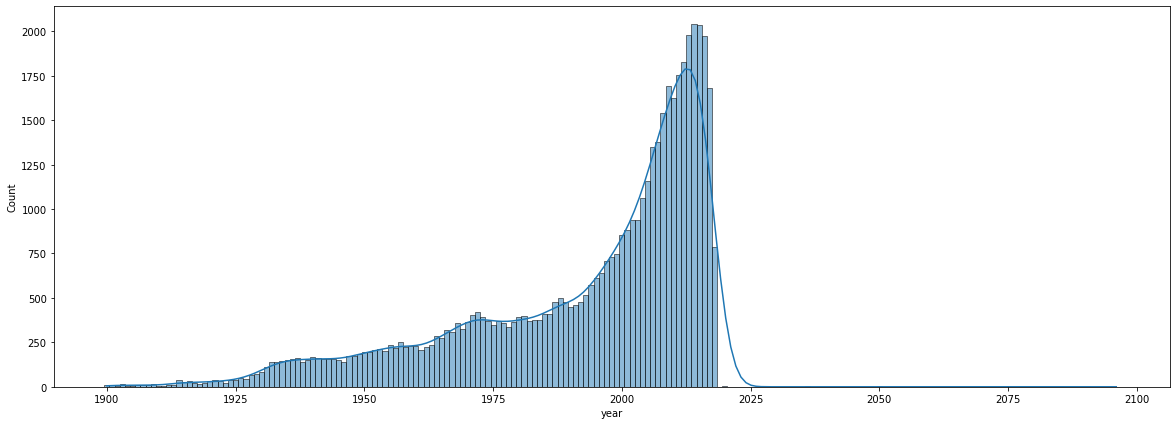

In [586]:
plt.figure(figsize=(20,7))
sns.histplot(df_year_without_na, kde=True, discrete=True)
plt.show()

Since it's not simmetric, we decide to fill `na` values with the *median*.

In [587]:
df.year = df.loc[:, 'year'].fillna(np.median(df_year_without_na)).astype('int')

We can check the absence of `Null` or `Na` values.

In [588]:
sum(pd.isna(df).any(axis=1))

0

After checking missing data and before checking duplicates, we drop the `movieId` column since contains unique values which are useful only to indexing purposes.

In [589]:
df.drop('movieId', inplace=True, axis=1)

### Checking duplicates 

There are $394$ duplicated rows.

In [590]:
sum(df.duplicated())

394

We have deleted them by keeping the first.

In [591]:
df.drop_duplicates(inplace=True)

So that, there aren't any duplicated row.

In [592]:
sum(df.duplicated())

0

As result of Data Cleaning we have the cardinality of $49792$ movies

In [593]:
len(df)

49792

## Data Trasformation

### Continuous label discretization

Binning by equal width boundaries (width: 0.9)

In [594]:
df['bin_y'] = pd.cut(df['rating_mean'], bins=NR_BINS, labels=False)

### Train/Test/Validation set splitting

In [595]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=13, stratify=df['bin_y'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=13, stratify=df_train['bin_y'])

After split we reset indexs

In [596]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Balancing Training Set

#### Evaluating

We evaluate to which extent bins are balanced.

In [597]:
df_train.bin_y.value_counts()

3    15797
2    14235
1     3671
4     1187
0      959
Name: bin_y, dtype: int64

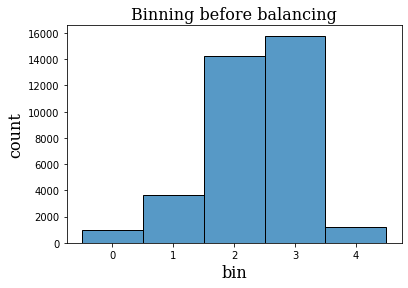

In [598]:
sns.histplot(df_train.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning before balancing", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "initial_binning.png"), facecolor='white', transparent=False)
plt.show()

In [599]:
len(df_train)

35849

#### SMOTE balancing 

##### function to dataset balancing with lower bound

In [600]:
def balancing(df_train, lower_bound, remove_duplicates=True):

	bins_count = df_train.bin_y.value_counts()
	for i in range(len(bins_count)):
		if bins_count[i] <= lower_bound:
			bins_count[i] = lower_bound

	bin_sizes = bins_count.to_dict()

	sm = SMOTE(random_state=43, sampling_strategy=bin_sizes)
	df_train_balanced, _ = sm.fit_resample(df_train, df_train['bin_y'])

	#rimuove i duplicati
	if remove_duplicates:
		df_train_balanced.drop_duplicates(inplace=True)

	return df_train_balanced.reset_index(drop=True)

##### Example of use

In [601]:
df_train_SMOTE = balancing(df_train, 5000, remove_duplicates=False)

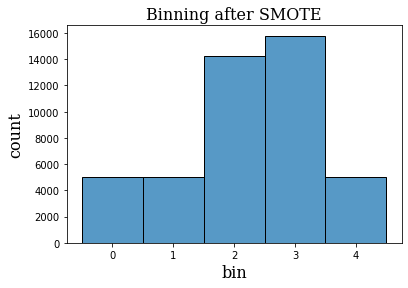

In [602]:
sns.histplot(df_train_SMOTE.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning after SMOTE", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "after_SMOTE_binning.png"),facecolor='white', transparent=False)
plt.show()

##### Checking new duplicates

In [603]:
df_train_SMOTE.duplicated().sum()

1339

In [604]:
df_train_SMOTE.drop_duplicates(inplace=True)

In [605]:
df_train_SMOTE.duplicated().sum()

0

Dopo eliminazione duplicati dal dataset di train, occorre ricavare y_train (la y_train in output da SMOTE contiene i duplicati che si sono prodotti).

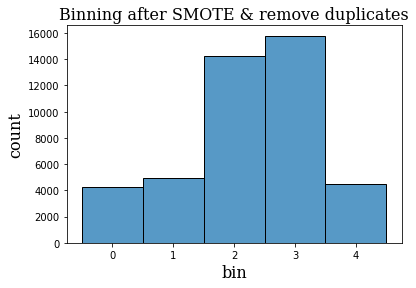

In [606]:
sns.histplot(df_train_SMOTE.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning after SMOTE & remove duplicates", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "after_SMOTE_and_removed_duplicates_binning.png"),facecolor='white', transparent=False)
plt.show()

##### SMOTE Balancing result

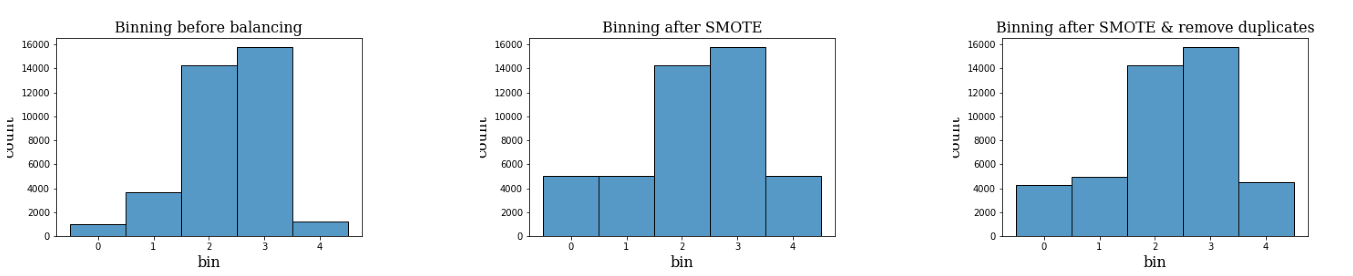

In [607]:
images = [os.path.join(image_path, "initial_binning.png"), os.path.join(image_path, "after_SMOTE_binning.png"), os.path.join(image_path, "after_SMOTE_and_removed_duplicates_binning.png")]
showImagesHorizontally(images)

#### Sub sets slicing

In [608]:
def generateSets(data, n_samples, size):
	samples = []
	data = shuffle(data, random_state=43).reset_index(drop=True)
	for s in range(n_samples):
		if(len(data) >= n_samples * size):
			start = s * size
			end = start + size
			samples.append(data.iloc[start:end])
		else:
			samples.append(data.sample(size, replace=False, ignore_index=True, random_state=43))

	return samples

with this function we want to select a n with subsets with the max distance possible itself

In [609]:
def RandomSubSets(df, size, n_samples): 
	df_samples = [pd.DataFrame(columns=df.columns) for _ in range(n_samples)]
	for c in df.bin_y.unique():       
		df_class_c = df[df.bin_y == c]
		df_class_sets = generateSets(df_class_c, n_samples, size)
		
		for i in range(n_samples):
			df_samples[i] = df_samples[i].append(df_class_sets[i], ignore_index=True)
	
	return df_samples

Example of use

In [610]:
min_bin_cardinality = df_train.bin_y.value_counts().min()
samples = RandomSubSets(df_train_SMOTE, 2000, 7)

C:\Users\esinagra\AppData\Local\Temp\ipykernel_54128\2053111843.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



resulting splitting

In [611]:
[len(x) for x in samples]

[10000, 10000, 10000, 10000, 10000, 10000, 10000]

SCRIVERE CHE SI STA PROCEDENDO SUI DATI BILANCIATI CON SMOTE

### Extracting X and y from Training/Validation/Test Set

In [612]:
def split_XYweights(df):
	y_categorical = df['bin_y'].astype('int')
	y_train_continuous = df['rating_mean'].astype('int')
	weights = df['ratings_count']
	X = df.drop(columns=['bin_y', 'rating_mean', 'ratings_count'], axis=1)
	
	return X, weights, y_categorical, y_train_continuous

Example of use

In [613]:
y_train_continuous = df_train['rating_mean']	
X_train, train_ratings_count, y_train_categorical, y_train_continuous = split_XYweights(df_train)

y_val_continuous = df_val['rating_mean']
X_val, val_ratings_count, y_val_categorical, y_test_continuous = split_XYweights(df_val)

y_test_categorical = df_test['bin_y']
X_test, test_ratings_count, y_test_categorical, y_test_continuous = split_XYweights(df_test)

### Evaluating Standardization or Min-Max Scaling

In [614]:
pd.set_option('display.max_rows', df.shape[0]+1)
X_train.describe().loc[['mean', 'min', 'max']]

year  title_length    Action  Adventure  Animation  Children  \
mean  1993.155988     26.215571  0.131384   0.075288   0.052024  0.053056   
min   1900.000000      3.000000  0.000000   0.000000   0.000000  0.000000   
max   2084.000000    158.000000  1.000000   1.000000   1.000000  1.000000   

        Comedy     Crime  Documentary     Drama   Fantasy  Film-Noir  \
mean  0.298502  0.094898     0.097213  0.449552  0.051773   0.007364   
min   0.000000  0.000000     0.000000  0.000000  0.000000   0.000000   
max   1.000000  1.000000     1.000000  1.000000  1.000000   1.000000   

        Horror      IMAX  Musical   Mystery   Romance    Sci-Fi  Thriller  \
mean  0.104075  0.004073  0.02226  0.052303  0.136963  0.066808  0.154174   
min   0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
max   1.000000  1.000000  1.00000  1.000000  1.000000  1.000000  1.000000   

           War   Western       007  007 (series)  18th century     1920s  \
mean  0.033585  0.021842  0.011803      0.011331       0.02143  0.020975   
min   0.000000  0.000000  0.000000      0.000000       0.00000  0.000000   
max   1.000000  1.000000  0.999750      1.000000       0.99750  0.930000   

         1930s     1950s     1960s    1970s     1980s  19th century        3d  \
mean  0.033072  0.026005  0.017514  0.04383  0.027919      0.016892  0.013643   
min   0.000000  0.000000  0.000000  0.00000  0.000000      0.000000  0.000000   
max   0.981000  0.921750  0.892000  0.91150  0.986250      0.914500  0.945500   

         70mm       80s      9/11   aardman  aardman studios  abortion  \
mean  0.01677  0.034545  0.004409  0.002013         0.014218  0.005343   
min   0.00000  0.000000  0.000000  0.000000         0.000000  0.000000   
max   0.99850  0.963250  0.963250  0.991000         1.000000  0.977250   

        absurd    action  action packed  adaptation  adapted from:book  \
mean  0.063178  0.068092       0.049138    0.096269           0.077183   
min   0.000000  0.000000       0.000000    0.000000           0.000000   
max   0.988000  0.993250       0.983500    0.928250           0.995250   

      adapted from:comic  adapted from:game  addiction  adolescence  adoption  \
mean            0.029316           0.008214   0.031681     0.034084  0.029293   
min             0.000000           0.000000   0.000000     0.000000  0.000000   
max             0.999000           0.999750   0.997250     0.994000  0.999250   

      adultery  adventure  affectionate   afi 100  afi 100 (laughs)  \
mean  0.041808    0.05895      0.064722  0.007268          0.019689   
min   0.000000    0.00000      0.000000  0.000000          0.000000   
max   0.997750    0.99625      0.955000  0.842250          0.999500   

      afi 100 (movie quotes)    africa  afterlife     aging      aids  \
mean                0.025944  0.012452   0.013703  0.029805  0.019592   
min                 0.000000  0.000000   0.000000  0.000000  0.000000   
max                 0.870500  0.997000   0.997500  0.936500  0.996000   

      airplane   airport    alaska  alcatraz  alcoholism     alien  \
mean   0.00533  0.006635  0.004362  0.004345    0.012391  0.014294   
min    0.00000  0.000000  0.000000  0.000000    0.000000  0.000000   
max    0.84750  0.998250  0.997250  0.983750    0.979750  0.999750   

      alien invasion    aliens  allegory  almodovar  alone in the world  \
mean        0.009701  0.018636  0.058376   0.004527            0.018936   
min         0.000000  0.000000  0.000000   0.000000            0.000000   
max         0.996000  0.996500  0.990250   0.993750            0.977000   

      alter ego  alternate endings  alternate history  alternate reality  \
mean   0.050108            0.03404           0.039794           0.037978   
min    0.000000            0.00000           0.000000           0.000000   
max    0.958750            0.96900           0.913250           0.979000   

      alternate universe  amazing cinematography  amazing photography  \
mean            0.0

The genres columns have `0` or `1` as values.\
We have evaluating the feasibility of the standardization over relevance tags by plotting the distribution.

Since the number of tags is too high, we have plotted the distribution of n randomly sampled tags. 

In [615]:
len(X_train.iloc[:,22:].columns)

1127

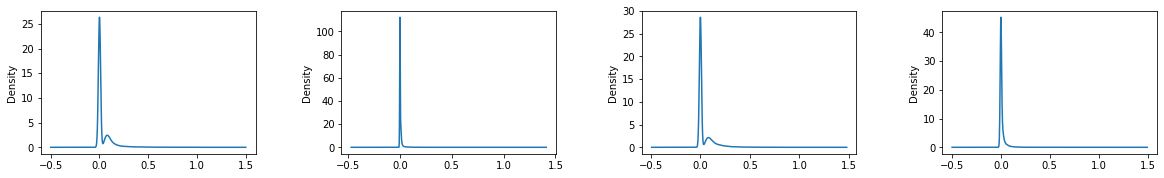

In [616]:
n = 4
columns_sampled = np.random.choice(df.iloc[:,21:-2].columns, 12, replace=False)

fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in np.arange(1,n+1):
    ax = fig.add_subplot(3, 4, i)
    X_train[columns_sampled[i-1]].plot(kind ='density')
plt.show()

Since it turns out that distributions aren't gaussian, we have excluded the standardization: the min-max scaling is pointless as values are already scaled between 0 and 1.  

#### MinMaxScaling function

In [617]:
def MinMaxScaling(X_train, X_val, X_test, cols):
	X_train_minmaxscaled = X_train.copy()
	X_val_minmaxscaled = X_val.copy()
	X_test_minmaxscaled = X_test.copy()
	
	for col in cols:
		min = np.min(X_train[col])
		max = np.max(X_train[col])
		range = max - min

		X_train_minmaxscaled[col] = (X_train[col] - min) / range
		X_val_minmaxscaled[col] = (X_val[col] - min) / range
		X_test_minmaxscaled[col] = (X_test[col] - min) / range

	return X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled

#### feature: title_len

Regarding the `title_legth` feature, we plot its distribution to evaluate the feasibility of the standardization.

In [618]:
pd.cut(df['title_length'], bins=len(X_train['title_length'].unique()), labels=False)

0          8
1          7
2         12
3         13
4         20
5          5
6          7
7         10
8         10
9          8
10        17
11        20
12         5
13         5
14        12
15         6
16        16
17         9
18        22
19         9
20         9
21         7
22         8
23         6
24        13
25         7
26        10
27         9
28        38
29        31
30        12
31        24
32        12
33         5
34         9
35        12
36        16
37        10
38         7
39        18
40         9
41        12
42         9
43        11
44         9
45        21
46        15
47         9
48        16
49        14
50        11
51        12
52         7
53        11
54         7
55        17
56        16
57        19
58        26
59        20
60        11
61        14
62        49
63        11
64         7
65        24
66         7
67        20
68         6
69        14
70         8
71        16
72        12
73        10
74         8
75         8
76         8

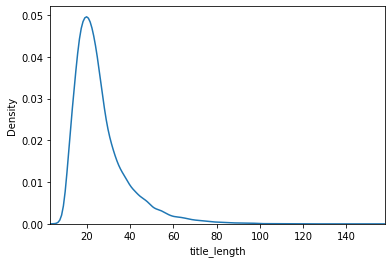

In [619]:
sns.kdeplot(X_train['title_length'])
plt.xlim([X_train['title_length'].min(), X_train['title_length'].max()])
plt.savefig(os.path.join(image_path, "initial_title_lenght.png"),facecolor='white', transparent=False)
plt.show()

Such distribution is not gaussian therefore we end up to apply *min-max scaling* in order to scale values in the range [0,1].

In [620]:
X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled = MinMaxScaling(X_train, X_val, X_test, ['title_length'])

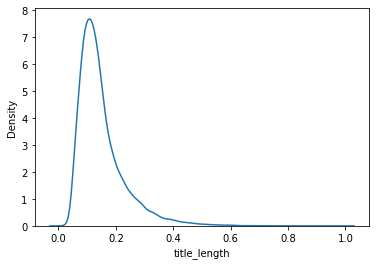

In [621]:
sns.kdeplot(X_train_minmaxscaled['title_length'])
plt.savefig(os.path.join(image_path, "after_minmaxscaled_title_lenght.png"), facecolor='white', transparent=False)
#plt.close()

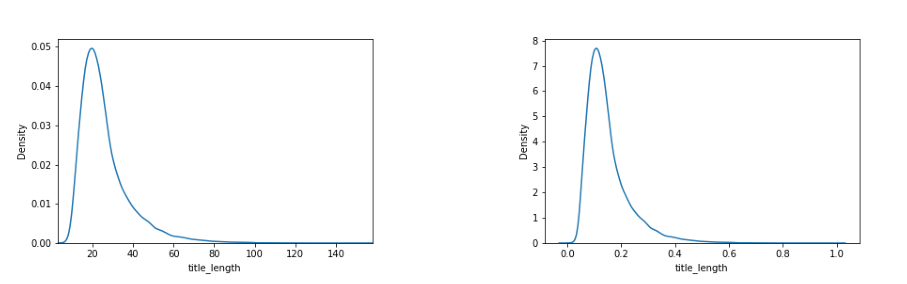

In [622]:
images = [os.path.join(image_path, "initial_title_lenght.png"), os.path.join(image_path, "after_minmaxscaled_title_lenght.png")]
showImagesHorizontally(images)

#### feature: year

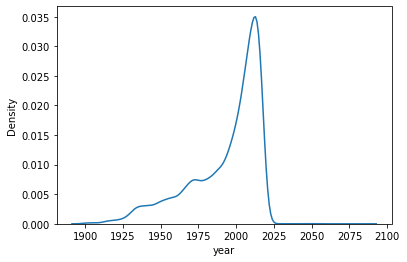

In [623]:
sns.kdeplot(X_train['year'])
plt.savefig(os.path.join(image_path, "initial_year.png"), facecolor='white', transparent=False)
plt.show()

In [624]:
X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled = MinMaxScaling(X_train, X_val, X_test, ['year'])

In [625]:
sns.kdeplot(X_train_minmaxscaled['year'])
plt.savefig(os.path.join(image_path, "after_minmaxscaled_year.png"), facecolor='white', transparent=False)
plt.close()

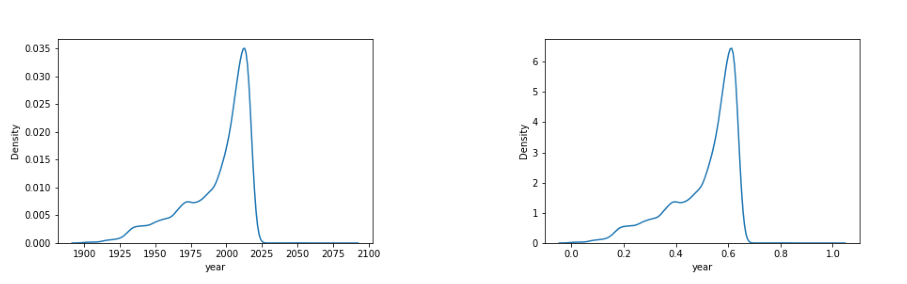

In [626]:
images = [os.path.join(image_path, "initial_year.png"), os.path.join(image_path, "after_minmaxscaled_year.png")]
showImagesHorizontally(images)

#### feature: ratings_count

In [627]:
train_ratings_count.loc[train_ratings_count> 80000]

736      84545
867      92406
12090    81815
21016    97999
27365    87899
Name: ratings_count, dtype: int32

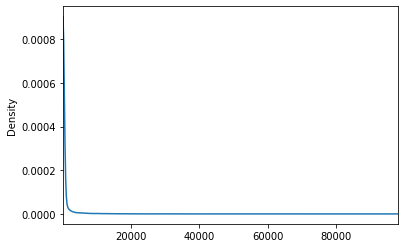

In [628]:
train_ratings_count.plot(kind='density', xlim=(train_ratings_count.min(), train_ratings_count.max()))
plt.savefig(os.path.join(image_path, "initial_ratings_count.png"), facecolor='white', transparent=False)
plt.show()

In [629]:
train_ratings_count_minmaxscaled, val_ratings_count_minmaxscaled, test_ratings_count_minmaxscaled = \
    MinMaxScaling(train_ratings_count.to_frame(), val_ratings_count.to_frame(), test_ratings_count.to_frame(), ['ratings_count'])

In [630]:
train_ratings_count_minmaxscaled = train_ratings_count_minmaxscaled.iloc[:,0]
train_ratings_count_minmaxscaled.plot(kind='density', xlim=(train_ratings_count_minmaxscaled.min(), train_ratings_count_minmaxscaled.max()))
plt.savefig(os.path.join(image_path, "after_minmaxscaled_ratings_count.png"), facecolor='white', transparent=False)
plt.close()

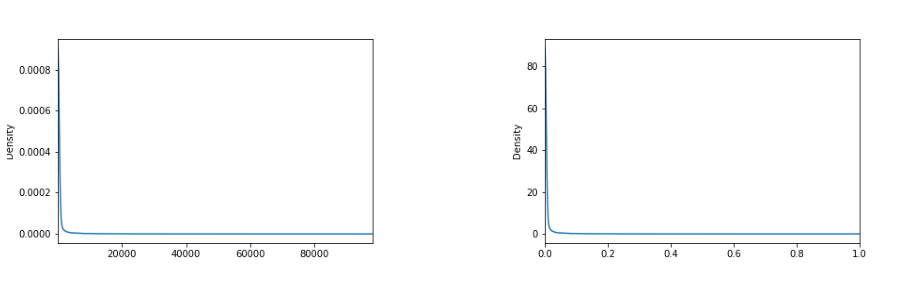

In [631]:
images = [os.path.join(image_path, "initial_ratings_count.png"), os.path.join(image_path, "after_minmaxscaled_ratings_count.png")]
showImagesHorizontally(images)

### Evaluating normalization

#### Normalization function

In [632]:
def normalization(X_train, ord):
	X_train_normalized = X_train.copy()
	X_train_normalized.iloc[:,:] = normalize(X_train, norm=ord)

	# alternative code in slides
	# x_norm2 = np.linalg.norm(x, ord=2)
	# x_normalized = x / x_norm2
	
	return X_train_normalized

#### Examples of use

L2 normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with L2 means that if each element were squared and summed, the total would equal 1

In [633]:
X_train_normalized_l2 = normalization(X_train, 'l2')

In [634]:
X_train_normalized_l1 = normalization(X_train, 'l1')

In [635]:
X_train_normalized_lmax = normalization(X_train, 'max')

In [636]:
X_train_normalized_SSRN = X_train.copy()
X_train_normalized_SSRN.iloc[:,:] = np.sign(X_train)*np.sqrt(np.abs(X_train))

In [637]:
X_train_minmaxscaled_normalized_SSRN = X_train_minmaxscaled.copy()
X_train_minmaxscaled_normalized_SSRN.iloc[:,:] = np.sign(X_train_minmaxscaled)*np.sqrt(np.abs(X_train_minmaxscaled))

In [638]:
showTablesHorizontally(
    [
        X_train_normalized_l2.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_l1.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_lmax.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']]
    ],
    [
        "X_train_normalized_l2",
        "X_train_normalized_l1",
        "X_train_normalized_lmax",
        "X_train_minmaxscaled",
        "X_train_normalized_SSRN",
        "X_train_minmaxscaled_normalized_SSRN"
    ])

### Dimensionality reduction

#### LDA function

In [639]:
def LDA(X_train, X_val, X_test, y, solver="eigen", debug=False):
	lda = LinearDiscriminantAnalysis(solver)
	lda.fit(X_train, y)

	#Kaiser Method or Variance Explained Cumulative Plot
	s = 0
	nr_canonical_variables = 1
	for comp in lda.explained_variance_ratio_:
		s += comp
		if s < 0.95:
			nr_canonical_variables += 1
		
	if debug:
		print(lda.explained_variance_ratio_)
		print(f"get first {nr_canonical_variables} eigenvalues")

	X_train = lda.transform(X_train)
	X_train = X_train[:,:nr_canonical_variables]
	X_train = pd.DataFrame(X_train, columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])

	X_val = pd.DataFrame(lda.transform(X_val)[:,:nr_canonical_variables], columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])
	X_test = pd.DataFrame(lda.transform(X_test)[:,:nr_canonical_variables], columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])

	return X_train, X_val, X_test

#### Example of use

In [640]:
a, b, c = LDA(X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled, y_train_categorical, solver='eigen', debug=True)

[0.71098098 0.18090701 0.08718618 0.02092583]
get first 3 eigenvalues


In [641]:
lda = LinearDiscriminantAnalysis(solver='eigen')
lda.fit(X_train_minmaxscaled, y_train_categorical)

LinearDiscriminantAnalysis(solver='eigen')

In [642]:
print(lda.explained_variance_ratio_)

[0.71098098 0.18090701 0.08718618 0.02092583]


Kaiser Method or Variance Explained Cumulative Plot

In [643]:
s = 0
nr_canonical_variables = 1
for comp in lda.explained_variance_ratio_:
	s += comp
	if s > 0.95:
		break
	nr_canonical_variables += 1

nr_canonical_variables

3

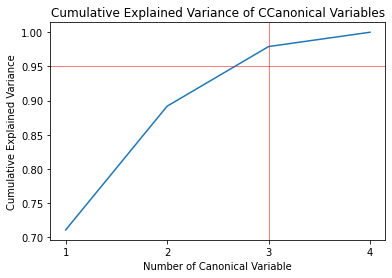

In [644]:
ax = figure().gca()
ax.plot(range(1, len(lda.explained_variance_ratio_) + 1), np.cumsum(lda.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Number of Canonical Variable')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of CCanonical Variables')

plt.axvline(x=3, linewidth=1, color='r', alpha=0.5)
plt.axhline(y=0.95, linewidth=1, color='r', alpha=0.5)
show()

In [645]:
X_train_minmaxscaled_reduced = lda.transform(X_train_minmaxscaled)

In [646]:
X_train_minmaxscaled_reduced = X_train_minmaxscaled_reduced[:,:nr_canonical_variables]

In [647]:
X_train_minmaxscaled_reduced = pd.DataFrame(
    X_train_minmaxscaled_reduced,
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

In [648]:
X_val_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_val_minmaxscaled)[:,:nr_canonical_variables],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])
X_test_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_test_minmaxscaled)[:,:nr_canonical_variables],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

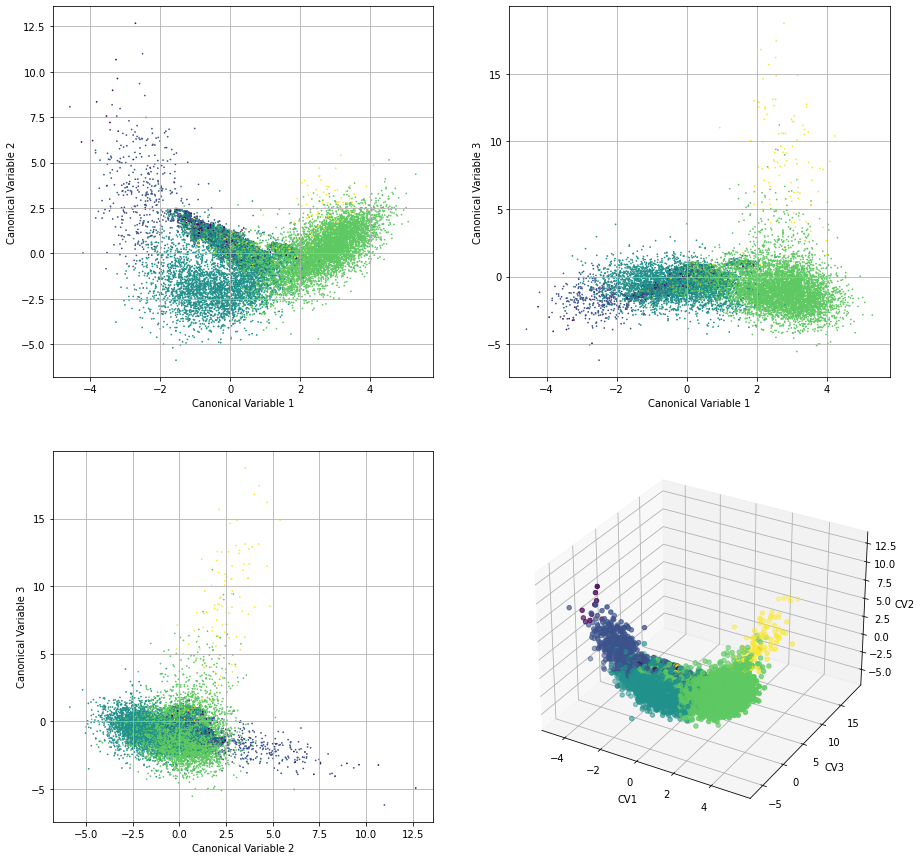

In [649]:
def myplot(n_cv1, n_cv2):
    cv1 = f"LD{n_cv1}"
    cv2 = f"LD{n_cv2}"
    cv1 = X_train_minmaxscaled_reduced[cv1]
    cv2 = X_train_minmaxscaled_reduced[cv2]

    plt.scatter(cv1 ,cv2, c = y_train_categorical, s = 0.5)

    plt.xlabel(f"Canonical Variable {n_cv1}")
    plt.ylabel(f"Canonical Variable {n_cv2}")
    plt.grid()

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
myplot(1, 2) 

plt.subplot(2, 2, 2)
myplot(1, 3) 

plt.subplot(2, 2, 3)
myplot(2, 3) 

ax = fig.add_subplot(2, 2, 4, projection='3d')
zdata = X_train_minmaxscaled_reduced.LD2
ydata = X_train_minmaxscaled_reduced.LD3
xdata = X_train_minmaxscaled_reduced.LD1
ax.set_xlabel('CV1')
ax.set_ylabel('CV3')
ax.set_zlabel('CV2')
ax.scatter3D(xdata, ydata, zdata, c=y_train_categorical)

In [650]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_train_minmaxscaled_reduced.LD1,
    y=X_train_minmaxscaled_reduced.LD3,
    z=X_train_minmaxscaled_reduced.LD2,
    mode='markers',
    marker=dict(
        size=2,
        color=y_train_categorical,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )  
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene = dict(
                    xaxis_title='CV1',
                    yaxis_title='CV3',
                    zaxis_title='CV2'))
fig.show()

# DATA MODELING

When computationally possible decided to tuning the dataframe sizes also using size that have unique samples size for voting

In [651]:
for i in range(9):
	size = df_train.bin_y.value_counts().max() / (i+1)
	print(f"size: {int(size)} with samples: {i+1} for voting")

size: 15797 with samples: 1 for voting
size: 7898 with samples: 2 for voting
size: 5265 with samples: 3 for voting
size: 3949 with samples: 4 for voting
size: 3159 with samples: 5 for voting
size: 2632 with samples: 6 for voting
size: 2256 with samples: 7 for voting
size: 1974 with samples: 8 for voting
size: 1755 with samples: 9 for voting


## SVM

### hyperparameters

In [652]:
sizes = [1755, 1974, 2256, 2632, 3159, 3949, 5265, 7898, 15797]
size = 4
nr_configurations = size*size*len(sizes)

C_range = np.geomspace(0.1, 100, size)
gamma_range = np.geomspace(0.1, 100, size)

In [653]:
C_range

array([  0.1,   1. ,  10. , 100. ])

### RBF kernel

##### tuning hyperparameters

In [ ]:
results = pd.DataFrame(columns=['size', 'samples', 'C', 'gamma', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
	
	for c in C_range:
		for gamma in gamma_range:
			y_val_preds = []
			config += 1
			print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, C: {c}, gamma: {gamma}")

			print("***********STARTING BAGGING***********")
			for n in range(len(df_trains)):
				print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

				print("PRE-PROCESSING --> split_XYweights")
				X_train, weights, y_train, _ = split_XYweights(df_trains[n])
				X_val, _, y_val, _ = split_XYweights(df_val)
				X_test, _, y_test, _ = split_XYweights(df_test)

				print("PRE-PROCESSING --> MinMaxScaling")
				X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

				print("PRE-PROCESSING --> LDA")
				X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

				print("FITTING & PREDICTING")
				svc = svm.SVC(kernel="rbf", C=c, gamma=gamma)
				svc.fit(X_train, y_train)

				y_val_pred = svc.predict(X_val).tolist()
				y_val_preds.append(y_val_pred)

				error = zero_one_loss(y_val, y_val_pred)
				print(f"LOSS --> {error}")

			print("***********ENDING BAGGING***********")

			nr_predictions = len(y_val_preds[0])
			y_val_pred_voted = []
			print("VOTING")
			for prediction in range(nr_predictions):
				y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

			loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
			print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")
			
			results = results.append({
				'size': size,
				'samples': n_sample,
				'C': c,
				'gamma': gamma,
				'loss_ensemble': loss_ensemble
			}, ignore_index=True)

we store the results

In [ ]:
results.to_csv(os.path.join(current_path, tuning_path,'SVC_rbf.csv'), index=False)

we load the results

In [ ]:
results = pd.read_csv(os.path.join(current_path, tuning_path,'SVC_rbf.csv'))

we select the best hyperparametes

In [ ]:
results.loc[results['loss_ensemble'] == results['loss_ensemble'].min()]

size  samples    C  gamma  loss_ensemble
134  15797.0      1.0  1.0   10.0       0.551707

The resulting loss ensamble is $0.551707$

##### test with best hyperparameters

In [655]:
size = 2000
c = 1
gamma = 1

In [539]:
y_test_preds = []

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train, weights, y_train, _ = split_XYweights(df_trains[n])
	X_val, _, y_val, _ = split_XYweights(df_val)
	X_test, _, y_test, _ = split_XYweights(df_test)

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

	print("PRE-PROCESSING --> LDA")
	X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

	print("FITTING & PREDICTING")
	svc = svm.SVC(kernel="rbf", C=c, gamma=gamma)
	svc.fit(X_train, y_train)

	y_test_pred = svc.predict(X_test).tolist()
	y_test_preds.append(y_test_pred)

	error = zero_one_loss(y_test, y_test_pred)
	print(f"LOSS --> {error}")

print("***********ENDING BAGGING***********")

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")

***********STARTING BAGGING***********
****1° FIT su 9° sample del train****
PRE-PROCESSING --> split_XYweights
PRE-PROCESSING --> MinMaxScaling
PRE-PROCESSING --> LDA


#####  result

### Custom kernel

#### Feature Engineering

Nella teoria dell'informazione, la distanza di Hamming tra due stringhe di ugual lunghezza è il numero di posizioni nelle quali i simboli corrispondenti sono diversi. 

We want to measure distances between samples by separately considering tags and genres: by the way, we have created two new columns:
- `genres` which collapses in a list the values corresponding to genres' columns;
- `tags` which collapses in a list the values corresponding to tags' columns.

In [ ]:
def distance(a,b):
	d = np.sqrt(np.square(np.subtract(a[0:2], b[0:2])).sum())     # distanze element wise tra year, title_length
	d += np.bitwise_xor(a[2], b[2]).sum()/len(a[2]) # hamming
	d += np.sqrt(np.square(np.subtract(a[3], b[3])).sum())
	return d

#### tuning hyperparameters

In [ ]:
#sizes = 1755
nr_configurations = size * size

In [ ]:
results = pd.DataFrame(columns=['C', 'gamma', 'loss_ensemble'])
config = 0

df_train = balancing(df_train, 1755)

df_train, df_val, df_test = MinMaxScaling(df_train, df_val, df_test, ["year", "title_length"])

print("CHANGING DATAFRAME FOR HAMMING")
df_train_ham = df_train.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_train_ham['genres'] = df_train.iloc[:,2:21].values.tolist()
df_train_ham['tags'] = df_train.iloc[:,22:-3].values.tolist()

df_val_ham = df_val.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_val_ham['genres'] = df_val.iloc[:,2:21].values.tolist()
df_val_ham['tags'] = df_val.iloc[:,22:-3].values.tolist()

df_test_ham = df_test.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_test_ham['genres'] = df_test.iloc[:,2:21].values.tolist()
df_test_ham['tags'] = df_test.iloc[:,22:-3].values.tolist()

min_size = df_train_ham.bin_y.value_counts().min()
n_sample = int(df_train_ham.bin_y.value_counts().max()/min_size)
df_trains = RandomSubSets(df_train_ham, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000

for c in C_range:
	for gamma in gamma_range:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> C: {c}, gamma: {gamma}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {n+1}° sample del train****")

			print("PRE-PROCESSING --> split_XYweights")
			X_train, weights, y_train, _ = split_XYweights(df_trains[n])
			X_val, _, y_val, _ = split_XYweights(df_val_ham)
			X_test, _, y_test, _ = split_XYweights(df_test_ham)

			#print("CHANGING DATAFRAME FOR HAMMING")
			#X_train = X_train_split.loc[:,["year", "title_length"]]
			#X_train['genres'] = X_train_split.iloc[:,2:21].values.tolist()
			#X_train['tags'] = X_train_split.iloc[:,22:].values.tolist()

			#X_val = X_val_split.loc[:,["year", "title_length"]]
			#X_val['genres'] = X_val_split.iloc[:,2:21].values.tolist()
			#X_val['tags'] = X_val_split.iloc[:,22:].values.tolist()

			#X_test = X_test_split.loc[:,["year", "title_length"]]
			#X_test['genres'] = X_test_split.iloc[:,2:21].values.tolist()
			#X_test['tags'] = X_test_split.iloc[:,22:].values.tolist()

			#print("PRE-PROCESSING --> MinMaxScaling")
			#X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ["year", "title_length"])

			print(X_train.head())

			print("FITTING & PREDICTING")
			train_distances = cdist(X_train.values, X_train.values, lambda a,b: distance(a,b))
			svc = svm.SVC(kernel="precomputed", C=c, gamma=gamma)
			svc.fit(train_distances, y_train)

			val_distances = cdist(X_val.values, X_train.values, lambda a,b: distance(a,b))
			y_val_pred = svc.predict(val_distances).tolist()
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val, y_val_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
		# therefore, len(y_val_preds) == len(df_trains)
		# 			 len(y_val_preds[idx]) == len(X_val_SVC) == nr different predictions, with idx the n-th sample
		
		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")
        
		results = results.append({
			'C': c,
			'gamma': gamma,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

In [ ]:
results.to_csv(os.path.join(current_path, tuning_path,'SVC_custom_kernel.csv'), index=False)

In [ ]:
pd.read_csv(os.path.join(current_path, tuning_path,'SVC_custom_kernel.csv'))

#### test with best hyperparameters

In [ ]:
c = 1
gamma = 1

In [ ]:
results = pd.DataFrame(columns=['C', 'gamma', 'loss_ensemble'])
config = 0

df_train = balancing(df_train, 1755)

df_train, df_val, df_test = MinMaxScaling(df_train, df_val, df_test, ["year", "title_length"])

print("CHANGING DATAFRAME FOR HAMMING")
df_train_ham = df_train.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_train_ham['genres'] = df_train.iloc[:,2:21].values.tolist()
df_train_ham['tags'] = df_train.iloc[:,22:-3].values.tolist()

df_val_ham = df_val.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_val_ham['genres'] = df_val.iloc[:,2:21].values.tolist()
df_val_ham['tags'] = df_val.iloc[:,22:-3].values.tolist()

df_test_ham = df_test.loc[:,["year", "title_length", "ratings_count", "bin_y", "rating_mean"]]
df_test_ham['genres'] = df_test.iloc[:,2:21].values.tolist()
df_test_ham['tags'] = df_test.iloc[:,22:-3].values.tolist()

min_size = df_train_ham.bin_y.value_counts().min()
n_sample = int(df_train_ham.bin_y.value_counts().max()/min_size)
df_trains = RandomSubSets(df_train_ham, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000

y_test_preds = []
config += 1

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {n+1}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train, weights, y_train, _ = split_XYweights(df_trains[n])
	X_val, _, y_val, _ = split_XYweights(df_val_ham)
	X_test, _, y_test, _ = split_XYweights(df_test_ham)

	print(X_train.head())

	print("FITTING & PREDICTING")
	train_distances = cdist(X_train.values, X_train.values, lambda a,b: distance(a,b))
	svc = svm.SVC(kernel="precomputed", C=c, gamma=gamma)
	svc.fit(train_distances, y_train)

	test_distances = cdist(X_test.values, X_train.values, lambda a,b: distance(a,b))
	y_test_pred = svc.predict(test_distances).tolist()
	y_test_preds.append(y_test_pred)

	error = zero_one_loss(y_val, y_test_pred)
	print(f"LOSS --> {error}")
print("***********ENDING BAGGING***********")

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")

results = results.append({
	'C': c,
	'gamma': gamma,
	'loss_ensemble': loss_ensemble
}, ignore_index=True)

CHANGING DATAFRAME FOR HAMMING


C:\Users\esinagra\AppData\Local\Temp\ipykernel_54128\2053111843.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



***********STARTING BAGGING***********
****1° FIT su 1° sample del train****
PRE-PROCESSING --> split_XYweights
       year title_length                                             genres  \
0  0.211957     0.135484  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  0.331522     0.122581  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  0.168478     0.064516  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...   
3  0.586957     0.109677  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  0.619565     0.129032  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...   

                                                tags  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.04775, 0.023, 0.0197499999999999, 0.0227499...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
FITTING & PREDICTING


NameError: name 'distance' is not defined

In [ ]:
X_train_SVC = X_train_minmaxscaled.loc[:,["year", "title_length"]]
X_train_SVC['genres'] = X_train_minmaxscaled.iloc[:,2:21].values.tolist()
X_train_SVC['tags'] = X_train_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_train_SVC = X_train_SVC.copy()
# df_train_SVC['bin_y'] = y_train_categorical

X_test_SVC = X_test_minmaxscaled.loc[:,["year", "title_length"]]
X_test_SVC['genres'] = X_test_minmaxscaled.iloc[:,2:21].values.tolist()
X_test_SVC['tags'] = X_test_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_test_SVC = X_test_SVC.copy()

In [ ]:
train_distances = cdist(X_train_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))
svc = svm.SVC(kernel="precomputed", C=1000)
svc.fit(train_distances, y_train_categorical)

In [ ]:
test_distances = cdist(X_test_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))
y_test_pred = svc.predict(test_distances)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.99


In [ ]:
results.to_csv(os.path.join(current_path, tuning_path,'SVC_custom_kernel.csv'), index=False)
pd.read_csv(os.path.join(current_path, tuning_path,'SVC_custom_kernel.csv'))

### result

The best resulting loss ensamble is $XXXX$ with XXX

## Naive Bayes

### preprocessing: discretize features

In [ ]:
n_cats = 4

In [ ]:
df_val_discrete = df_val.copy()
df_val_discrete.iloc[:, 21:-3] = df_val_discrete.iloc[:, 21:-3].apply(lambda x: pd.cut(x, n_cats, labels=range(n_cats)), axis=1)

In [ ]:
df_test_discrete = df_test.copy()
df_test_discrete.iloc[:, 21:-3] = df_test_discrete.iloc[:, 21:-3].apply(lambda x: pd.cut(x, n_cats, labels=range(n_cats)),axis=1)

In [ ]:
df_train_discrete = df_train.copy()
df_train_discrete.iloc[:,21:-3] = df_train_discrete.iloc[:, 21:].apply(lambda x: pd.cut(x, n_cats, labels=range(n_cats)),axis=1)

In [ ]:
df_val_discrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3984 entries, 0 to 3983
Columns: 1152 entries, year to bin_y
dtypes: float64(1), int32(1149), int64(2)
memory usage: 17.6 MB


output

In [ ]:
df_val.iloc[:,21:-3].head()

007  007 (series)  18th century  1920s  1930s  1950s  1960s  1970s  1980s  \
0  0.0           0.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.0           0.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.0           0.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.0           0.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4  0.0           0.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   19th century   3d  70mm  80s  9/11  aardman  aardman studios  abortion  \
0           0.0  0.0   0.0  0.0   0.0      0.0              0.0       0.0   
1           0.0  0.0   0.0  0.0   0.0      0.0              0.0       0.0   
2           0.0  0.0   0.0  0.0   0.0      0.0              0.0       0.0   
3           0.0  0.0   0.0  0.0   0.0      0.0              0.0       0.0   
4           0.0  0.0   0.0  0.0   0.0      0.0              0.0       0.0   

   absurd  action  action packed  adaptation  adapted from:book  \
0     0.0     0.0            0.0         0.0                0.0   
1     0.0     0.0            0.0         0.0                0.0   
2     0.0     0.0            0.0         0.0                0.0   
3     0.0     0.0            0.0         0.0                0.0   
4     0.0     0.0            0.0         0.0                0.0   

   adapted from:comic  adapted from:game  addiction  adolescence  adoption  \
0                 0.0                0.0        0.0          0.0       0.0   
1                 0.0                0.0        0.0          0.0       0.0   
2                 0.0                0.0        0.0          0.0       0.0   
3                 0.0                0.0        0.0          0.0       0.0   
4                 0.0                0.0        0.0          0.0       0.0   

   adultery  adventure  affectionate  afi 100  afi 100 (laughs)  \
0       0.0        0.0           0.0      0.0               0.0   
1       0.0        0.0           0.0      0.0               0.0   
2       0.0        0.0           0.0      0.0               0.0   
3       0.0        0.0           0.0      0.0               0.0   
4       0.0        0.0           0.0      0.0               0.0   

   afi 100 (movie quotes)  africa  afterlife  aging  aids  airplane  airport  \
0                     0.0     0.0        0.0    0.0   0.0       0.0      0.0   
1                     0.0     0.0        0.0    0.0   0.0       0.0      0.0   
2                     0.0     0.0        0.0    0.0   0.0       0.0      0.0   
3                     0.0     0.0        0.0    0.0   0.0       0.0      0.0   
4                     0.0     0.0        0.0    0.0   0.0       0.0      0.0   

   alaska  alcatraz  alcoholism  alien  alien invasion  aliens  allegory  \
0     0.0       0.0         0.0    0.0             0.0     0.0       0.0   
1     0.0       0.0         0.0    0.0             0.0     0.0       0.0   
2     0.0       0.0         0.0    0.0             0.0     0.0       0.0   
3     0.0       0.0         0.0    0.0             0.0     0.0       0.0   
4     0.0       0.0         0.0    0.0             0.0     0.0       0.0   

   almodovar  alone in the world  alter ego  alternate endings  \
0        0.0                 0.0        0.0                0.0   
1        0.0                 0.0        0.0                0.0   
2        0.0                 0.0        0.0                0.0   
3        0.0                 0.0        0.0                0.0   
4        0.0                 0.0        0.0                0.0   

   alternate history  alternate reality  alternate universe  \
0                0.0                0.0                 0.0   
1                0.0                0.0                 0.0   
2                0.0                0.0                 0.0   
3                0.0                0.0                 0.0   
4                0.0                0.0                 0.0   

   amazing cinematography  amazing photography  american civil war  am

In [ ]:
df_val_discrete.iloc[:,21:-3].head()

007  007 (series)  18th century  1920s  1930s  1950s  1960s  1970s  1980s  \
0    1             1             1      1      1      1      1      1      1   
1    1             1             1      1      1      1      1      1      1   
2    1             1             1      1      1      1      1      1      1   
3    1             1             1      1      1      1      1      1      1   
4    1             1             1      1      1      1      1      1      1   

   19th century  3d  70mm  80s  9/11  aardman  aardman studios  abortion  \
0             1   1     1    1     1        1                1         1   
1             1   1     1    1     1        1                1         1   
2             1   1     1    1     1        1                1         1   
3             1   1     1    1     1        1                1         1   
4             1   1     1    1     1        1                1         1   

   absurd  action  action packed  adaptation  adapted from:book  \
0       1       1              1           1                  1   
1       1       1              1           1                  1   
2       1       1              1           1                  1   
3       1       1              1           1                  1   
4       1       1              1           1                  1   

   adapted from:comic  adapted from:game  addiction  adolescence  adoption  \
0                   1                  1          1            1         1   
1                   1                  1          1            1         1   
2                   1                  1          1            1         1   
3                   1                  1          1            1         1   
4                   1                  1          1            1         1   

   adultery  adventure  affectionate  afi 100  afi 100 (laughs)  \
0         1          1             1        1                 1   
1         1          1             1        1                 1   
2         1          1             1        1                 1   
3         1          1             1        1                 1   
4         1          1             1        1                 1   

   afi 100 (movie quotes)  africa  afterlife  aging  aids  airplane  airport  \
0                       1       1          1      1     1         1        1   
1                       1       1          1      1     1         1        1   
2                       1       1          1      1     1         1        1   
3                       1       1          1      1     1         1        1   
4                       1       1          1      1     1         1        1   

   alaska  alcatraz  alcoholism  alien  alien invasion  aliens  allegory  \
0       1         1           1      1               1       1         1   
1       1         1           1      1               1       1         1   
2       1         1           1      1               1       1         1   
3       1         1           1      1               1       1         1   
4       1         1           1      1               1       1         1   

   almodovar  alone in the world  alter ego  alternate endings  \
0          1                   1          1                  1   
1          1                   1          1                  1   
2          1                   1          1                  1   
3          1                   1          1                  1   
4          1                   1          1                  1   

   alternate history  alternate reality  alternate universe  \
0                  1                  1                   1   
1                  1                  1                   1   
2                  1                  1                   1   
3                  1                  1                   1   
4                  1                  1                   1   

   amazing cinematography  amazing photography  american civil war  amnesia 

### tuning hyperparameters

In [ ]:
sizes = [7898, 15797]
types = ["CategoricalNB", "GaussianNB", "QuadraticDiscriminantAnalysis"]
nr_configurations = len(sizes)*len(types)

In [ ]:
results = pd.DataFrame(columns=['size', 'sample', 'technique', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
	
	for t in types:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, technique {t}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")
			
			print("PRE-PROCESSING --> split_XYweights")
			X_train, weights, y_train, _ = split_XYweights(df_trains[n])
			X_val, _, y_val, _ = split_XYweights(df_val)
			X_test, _, y_test, _ = split_XYweights(df_test)

			print("PRE-PROCESSING --> MinMaxScaling")
			X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])
			print("PRE-PROCESSING --> LDA")
			X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

			if t == "CategoricalNB":
				print("DISCRETIZATION for CategoricalNB")
				n_cat_LD1 = int((X_train['LD1'].max() - X_train['LD1'].min()) * 2)
				n_cat_LD2 = int((X_train['LD2'].max() - X_train['LD2'].min()) * 2)
				n_cat_LD3 = int((X_train['LD3'].max() - X_train['LD3'].min()) * 2)
				print(f"bins for LD1 are: {n_cat_LD1}")
				print(f"bins for LD2 are: {n_cat_LD2}")
				print(f"bins for LD3 are: {n_cat_LD3}")

				X_train['LD1'] = pd.cut(X_train['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_train['LD2'] = pd.cut(X_train['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_train['LD3'] = pd.cut(X_train['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				X_val['LD1'] = pd.cut(X_val['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_val['LD2'] = pd.cut(X_val['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_val['LD3'] = pd.cut(X_val['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				X_test['LD1'] = pd.cut(X_test['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_test['LD2'] = pd.cut(X_test['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_test['LD3'] = pd.cut(X_test['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				clf = CategoricalNB()
			elif t == "GaussianNB":
				clf = GaussianNB()
			else:
				clf = QuadraticDiscriminantAnalysis()
				
			print("FITTING & PREDICTING")
			if t == "CategoricalNB":
				#sample_weight is always the best choice
				clf.fit(X_train, y_train, sample_weight=weights)
			else:
				clf.fit(X_train, y_train)
			
			y_val_pred = clf.predict(X_val).tolist()
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val, y_val_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (size: {size}, samples: {n_sample} 'technique': {t}) --> {loss_ensemble}\n\n")

		results = results.append({
			'size': size,
			'sample': n_sample,
			'technique': t,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

we store the results

In [ ]:
results.to_csv(os.path.join(current_path, tuning_path,'bayes.csv'), index=False)

we load the results

In [656]:
results = pd.read_csv(os.path.join(current_path, tuning_path,'bayes.csv'))

we select the best hyperparametes

In [657]:
results.loc[results['loss_ensemble'] == results['loss_ensemble'].min()]

size  sample      technique  loss_ensemble
3  15797       1  CategoricalNB       0.475402

### test with best hyperparameters

In [658]:
sizes = [15797]
types = ["CategoricalNB"]
nr_configurations = len(sizes)*len(types)

In [659]:
results = pd.DataFrame(columns=['size', 'sample', 'technique', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
	
	for t in types:
		y_test_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, technique {t}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")
			
			print("PRE-PROCESSING --> split_XYweights")
			X_train, weights, y_train, _ = split_XYweights(df_trains[n])
			X_val, _, y_val, _ = split_XYweights(df_val)
			X_test, _, y_test, _ = split_XYweights(df_test)

			print("PRE-PROCESSING --> MinMaxScaling")
			X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])
			print("PRE-PROCESSING --> LDA")
			X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

			if t == "CategoricalNB":
				print("DISCRETIZATION for CategoricalNB")
				n_cat_LD1 = int((X_train['LD1'].max() - X_train['LD1'].min()) * 2)
				n_cat_LD2 = int((X_train['LD2'].max() - X_train['LD2'].min()) * 2)
				n_cat_LD3 = int((X_train['LD3'].max() - X_train['LD3'].min()) * 2)
				print(f"bins for LD1 are: {n_cat_LD1}")
				print(f"bins for LD2 are: {n_cat_LD2}")
				print(f"bins for LD3 are: {n_cat_LD3}")

				X_train['LD1'] = pd.cut(X_train['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_train['LD2'] = pd.cut(X_train['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_train['LD3'] = pd.cut(X_train['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				X_val['LD1'] = pd.cut(X_val['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_val['LD2'] = pd.cut(X_val['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_val['LD3'] = pd.cut(X_val['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				X_test['LD1'] = pd.cut(X_test['LD1'], bins=n_cat_LD1, labels=range(n_cat_LD1))
				X_test['LD2'] = pd.cut(X_test['LD2'], bins=n_cat_LD2, labels=range(n_cat_LD2))
				X_test['LD3'] = pd.cut(X_test['LD3'], bins=n_cat_LD3, labels=range(n_cat_LD3))

				clf = CategoricalNB()
			elif t == "GaussianNB":
				clf = GaussianNB()
			else:
				clf = QuadraticDiscriminantAnalysis()
				
			print("FITTING & PREDICTING")
			if t == "CategoricalNB":
				#sample_weight is always the best choice
				clf.fit(X_train, y_train, sample_weight=weights)
			else:
				clf.fit(X_train, y_train)
			
			y_test_pred = clf.predict(X_test).tolist()
			Z = clf.predict_proba(X_test)
			y_test_preds.append(y_test_pred)

			error = zero_one_loss(y_test, y_test_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		nr_predictions = len(y_test_preds[0])
		y_test_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
		print(f"LOSS ENSEMBLE (size: {size}, samples: {n_sample} 'technique': {t}) --> {loss_ensemble}\n\n")

		results = results.append({
			'size': size,
			'sample': n_sample,
			'technique': t,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

***********BALANCING DATASET***********


C:\Users\esinagra\AppData\Local\Temp\ipykernel_54128\2053111843.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



************************************** 1 out of 1 params' configurations --> size: 15797, samples: 1, technique CategoricalNB
***********STARTING BAGGING***********
****1° FIT su 1° sample del train****
PRE-PROCESSING --> split_XYweights
PRE-PROCESSING --> MinMaxScaling
PRE-PROCESSING --> LDA
DISCRETIZATION for CategoricalNB
bins for LD1 are: 20
bins for LD2 are: 26
bins for LD3 are: 25
FITTING & PREDICTING
LOSS --> 0.520132543428055
***********ENDING BAGGING***********
VOTING
LOSS ENSEMBLE (size: 15797, samples: 1 'technique': CategoricalNB) --> 0.520132543428055




C:\Users\esinagra\AppData\Local\Temp\ipykernel_54128\1032194264.py:81: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [660]:
loss_ensemble

0.520132543428055

### result

The best resulting loss ensamble is $0.520132543428055$ with CategoricalNB.

We check for overfitting and underfitting.

In [ ]:
print('Training set accuracy: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set accuracy: {:.4f}'.format(clf.score(X_test, y_test)))

By definition a confusion matrix C is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_voted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[   2   47  142   26   49]
 [   4  211  467  153  185]
 [   0  253 2233  791  678]
 [   1   73 1173 2183  958]
 [   1    3   90   86  150]]


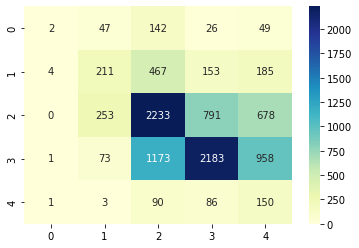

In [ ]:
cm_matrix = pd.DataFrame(data=cm)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [ ]:
print(classification_report(y_test, y_test_pred_voted))

              precision    recall  f1-score   support

           0       0.25      0.01      0.01       266
           1       0.36      0.21      0.26      1020
           2       0.54      0.56      0.55      3955
           3       0.67      0.50      0.57      4388
           4       0.07      0.45      0.13       330

    accuracy                           0.48      9959
   macro avg       0.38      0.35      0.31      9959
weighted avg       0.56      0.48      0.50      9959



## Random Forest

### tuning hyperparameters

#### set hyperparameters

In [306]:
sizes = [1755, 1974, 2256, 2632, 3159, 3949, 5265, 7898, 15797]
n_estimators = [10, 40, 70, 90]
n_criterion = ["gini", "entropy"]
n_bootstrap = [True, False]
class_weight = ["balanced", "balanced_subsample"]
#ccp_alpha # da capire quali sono i valori soliti
#sul fit avrebbe senso valutare con
#sample_weight = ["ratings_count", None]

nr_configurations = len(sizes)*len(n_estimators)*len(n_criterion)*len(n_bootstrap)*len(class_weight)

#### tuning hyperparameters

In [ ]:
results = pd.DataFrame(columns=['size', 'samples', 'n_estimators', 'criterion', 'bootstrap', 'class_weight', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
	
	for estimator in n_estimators:
		for criterio in n_criterion:
			for boot in n_bootstrap:
				for weight in class_weight:
					y_val_preds = []
					config += 1
					print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}")

					print("***********STARTING BAGGING***********")
					for n in range(len(df_trains)):
						print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

						print("PRE-PROCESSING --> split_XYweights")
						X_train, weights, y_train, _, = split_XYweights(df_trains[n])
						X_val, _, y_val, _ = split_XYweights(df_val)
						X_test, _, y_test, _ = split_XYweights(df_test)

						print("PRE-PROCESSING --> MinMaxScaling")
						X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

						#print("PRE-PROCESSING --> LDA")
						#X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

						print("FITTING & PREDICTING")
						rf = RandomForestClassifier(n_estimators=estimator, criterion=criterio, bootstrap=boot, class_weight=weight, random_state = 43, n_jobs=-1)
						rf.fit(X_train, y_train)

						y_val_pred = rf.predict(X_val).tolist()
						y_val_preds.append(y_val_pred)

						error = zero_one_loss(y_val, y_val_pred)
						print(f"LOSS --> {error}")
					print("***********ENDING BAGGING***********")

					nr_predictions = len(y_val_preds[0])
					y_val_pred_voted = []
					print("VOTING")
					for prediction in range(nr_predictions):
						y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

					loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
					print(f"LOSS ENSEMBLE (n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}) --> {loss_ensemble}\n\n")
					
					results = results.append({
						'size': size,
						'samples': n_sample,
						'n_estimators': estimator,
						'criterion': criterio,
						'bootstrap': boot,
						'class_weight': weight,
						'loss_ensemble': loss_ensemble
					}, ignore_index=True)

we store the results

In [ ]:
results.to_csv(os.path.join(current_path, tuning_path,'random_forest.csv'), index=False)

we load the results

In [540]:
results = pd.read_csv(os.path.join(current_path, tuning_path,'random_forest.csv'))

we select the best hyperparametes

In [541]:
results.loc[results['loss_ensemble'] == results['loss_ensemble'].min()]

size  samples  n_estimators criterion  bootstrap        class_weight  \
285  15797        1            90   entropy       True  balanced_subsample   

     loss_ensemble  
285       0.502008

### test with best hyperparameters

In [210]:
size = 15797
estimator = 90
criterio = "entropy"
boot = True
weight = "balanced_subsample"

df_train_SMOTE = balancing(df_train, size)
n_sample = int(df_train.bin_y.value_counts().max()/size)
min_size = df_train_SMOTE.bin_y.value_counts().min()
df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000

C:\Users\esinagra\AppData\Local\Temp\ipykernel_45848\2053111843.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [211]:
y_test_preds = []

print(f"params' configurations --> size: {size}, samples: {n_sample}, n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}")

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train, weights, y_train, weights = split_XYweights(df_trains[n])
	X_val, _, y_val, _ = split_XYweights(df_val)
	X_test, _, y_test, _ = split_XYweights(df_test)

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

	print("FITTING & PREDICTING")
	rf = RandomForestClassifier(n_estimators=estimator, criterion=criterio, bootstrap=boot, class_weight=weight, random_state = 43, n_jobs=-1)
	rf.fit(X_train, y_train)

	y_test_pred = rf.predict(X_test).tolist()
	y_test_preds.append(y_test_pred)
	
	error = zero_one_loss(y_test, y_test_pred)
	print(f"LOSS --> {error}")
print("***********ENDING BAGGING***********")

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])
	
loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}) --> {loss_ensemble}\n\n")

params' configurations --> size: 15797, samples: 1, n_estimators: 90, criterion: entropy, bootstrap: True, class_weight: balanced_subsample
***********STARTING BAGGING***********
****1° FIT su 1° sample del train****
PRE-PROCESSING --> split_XYweights
PRE-PROCESSING --> MinMaxScaling
FITTING & PREDICTING
LOSS --> 0.5118987850185761
***********ENDING BAGGING***********
VOTING
LOSS ENSEMBLE (n_estimators: 90, criterion: entropy, bootstrap: True, class_weight: balanced_subsample) --> 0.5118987850185761




#### Store columns relevance

In [ ]:
df_importance = pd.DataFrame([rf.feature_importances_], columns=X_train.columns)
df_importance.to_csv(os.path.join(current_path, results_path,'random_forest_feature_importances.csv'), index=False)

### result

The resulting loss ensamble is $0.5118987850185761$

In [213]:
loss_ensemble

0.5118987850185761

#### Column relevance

load columns relevance

In [216]:
df_importance = pd.read_csv(os.path.join(current_path, results_path,'random_forest_feature_importances.csv'))

In [217]:
features_importance = pd.DataFrame([df_importance.iloc[0]], columns=X_train.columns)

plot first 5 columns relevance

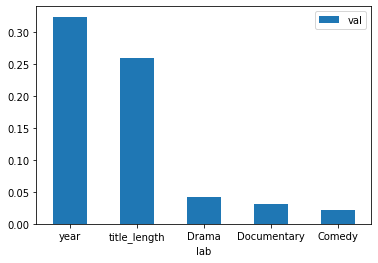

In [219]:
first = 5
features_importance = df_importance.sum().sort_values(ascending=False)
df = pd.DataFrame({'lab':features_importance.iloc[:first].index, 'val':features_importance.iloc[:first]})
ax = df.plot.bar(x='lab', y='val', rot=0)

print graphs in PNG/SVG but too much large to diplay

In [ ]:
from sklearn.tree import export_graphviz

for n in range(len(rf.estimators_)):
	export_graphviz(rf.estimators_[n], 
			out_file=os.path.join(results_path, f'tree_{n}.dot'), 
			feature_names = X_train.columns,
			rounded = True, proportion = False, 
			precision = 2, filled = True)
	
	dot = os.path.join(results_path, f'tree_{n}.dot')
	png = os.path.join(results_path, f'tree_{n}.png')
	dot = f'tree_{n}.dot'
	png = f'tree_{n}.png'
	command = f"dot -Tsvg \"{dot}\" -o \"{png}\""
	print(command)
	#os.system(f"dot -Tpng {dot} -o {png} - Gdpi=600")

# CONCLUSION

In order to predict a movie rating we build or data pipeline:

Data acquisition -> Data Pre-processing + Visualization -> Modeling -> Performance analysis + Visualization 

We find the best hyperparameters foreach method and we test the results.

Interesting note is that the best results are with a data balancing to the high class cardinality with SMOTE function.

## Tests comparison

Random Forest loss ensemble is $0.5118987850185761$ with params' configurations --> size: 15797, samples: 1, n_estimators: 90, criterion: entropy, bootstrap: True, class_weight: balanced_subsample

CategoricalNB loss ensemble is $0.520132543428055$ with params' configurations --> size: 15797, samples: 1

SVC RBF loss ensemble is $XXXX$ with params' configurations --> size: 15797, samples: 1 .....

# FUTURE WORKS

## Parallel computing in preprocessing

In [ ]:
'''
    alternative code in case .fillna is too computationally intensive
'''

# df.to_csv("df_per_fillna.csv", index=False)
# 
# #os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# 
# import dask
# import modin.pandas as pd_mod
# df_temp = pd_mod.read_csv("df_per_fillna.csv")
# df_temp.fillna(value=0)
# df_temp.to_csv("df_without_na.csv")
# df = pd.read_csv("df_without_na.csv")

'\n    alternative code in case .fillna is too computationally intensive\n'

## BalancedBaggingClassifier

## Bagging voting per maggioranza, in caso di pareggio selezione classe con somma di ratings_count maggiore

# Jovian

In [1]:
import jovian

<IPython.core.display.Javascript object>

In [3]:
jovian.commit(project="project-data-analytics", filename="notebook.ipynb", git_message="2° commit to Jovian", git_commit=True)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mickperl/project-data-analytics" on https://jovian.ai/
[jovian] Git repository identified. Performing git commit...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/mickperl/project-data-analytics


'https://jovian.ai/mickperl/project-data-analytics'